In [50]:
using Roots
using Printf
using HCubature
using CairoMakie
using OrdinaryDiffEq 

# Spherical Pendulum

First step is to define the system and solve it using a solver. I will use Vern9 because it is fast and has enough precision for this problem. The system is defined as follows:

$$
\begin{align*}
\ddot \theta &= \phi^2 \sin(\theta) \cos(\theta) - \frac{g}{l} \sin(\theta) \\
\ddot \phi &= -2 \dot \theta \dot \phi \cot(\theta)
\end{align*}
$$

Where $\theta$ is the angle of the pendulum with respect to the vertical and $\phi$ is the angle of the pendulum with respect to the horizontal. $g$ is the acceleration due to gravity and $l$ is the length of the pendulum. Solvers can only solve first order differential equations, so we need to convert these second order equations to first order equations as follows:

$$
\begin{align*}
\dot \theta &= v \\
\dot \phi &= w \\
\dot v &= \phi^2 \sin(\theta) \cos(\theta) - \frac{g}{l} \sin(\theta) \\
\dot w &= -2 \dot \theta \dot \phi \cot(\theta)
\end{align*}
$$

*Note*: Check the `interactive_pendulum_Lz.jl` file for a more interactive view of the problem


In [51]:
# Random initial conditions. You can change these to see different behaviors*
y₀ = [
    π/3, # θ
    0.0, # ϕ
    0.0, # θ̇
    π/4  # ϕ̇
]

g = 9.81 # Gravity constant
l = 3.0  # Length of the rod
m = 1.0  # Mass of the ball

p = [g,l,m]

function spherical_pendulum!(du, u, p, t)
    # Spherical pendulum system of ODEs
    θ, ϕ, θ̇, ϕ̇ = u
    g, l, m = p
    
    du[1] = θ̇
    du[2] = ϕ̇
    du[3] = ϕ̇^2 * sin(θ) * cos(θ) - g/l * sin(θ)
    du[4] = -2 * θ̇ * ϕ̇ * cot(θ)
    return nothing
end

total_time = 20.0
problem = ODEProblem(spherical_pendulum!, y₀, (0.0, total_time), p)
sol = solve(problem, Vern9());

Let's plot the solution!

In [52]:
function to_cartesian(θ, ϕ, l)
    # Convert spherical coordinates to cartesian
    X = l * sin.(θ) .* cos.(ϕ)
    Y = l * sin.(θ) .* sin.(ϕ)
    Z = l * cos.(θ)
    return X, Y, -Z
end

to_cartesian (generic function with 1 method)

In [53]:
# This is just for the plot disk at the bottom.
max_θ = maximum(sol[1,:])
grid_size = 50
Φ = range(0, 2π, grid_size) * ones(grid_size)'
Θ = ones(grid_size) * range(0, max_θ, grid_size)'

X, Y, Z = to_cartesian(Θ, Φ, p[2]);

In [54]:
frames = Observable(0.0)
trajectory = @lift sol(0:0.1:$frames)
cartesian = @lift to_cartesian($trajectory[1,:], $trajectory[2,:], p[2])
x = @lift $cartesian[1]
y = @lift $cartesian[2]
z = @lift $cartesian[3]
xₜ = @lift $x[end]
yₜ = @lift $y[end]
zₜ = @lift $z[end]
rodx = @lift [0, $xₜ]
rody = @lift [0, $yₜ]
rodz = @lift [0, $zₜ]

Observable([0.0, -1.5000000000000004])


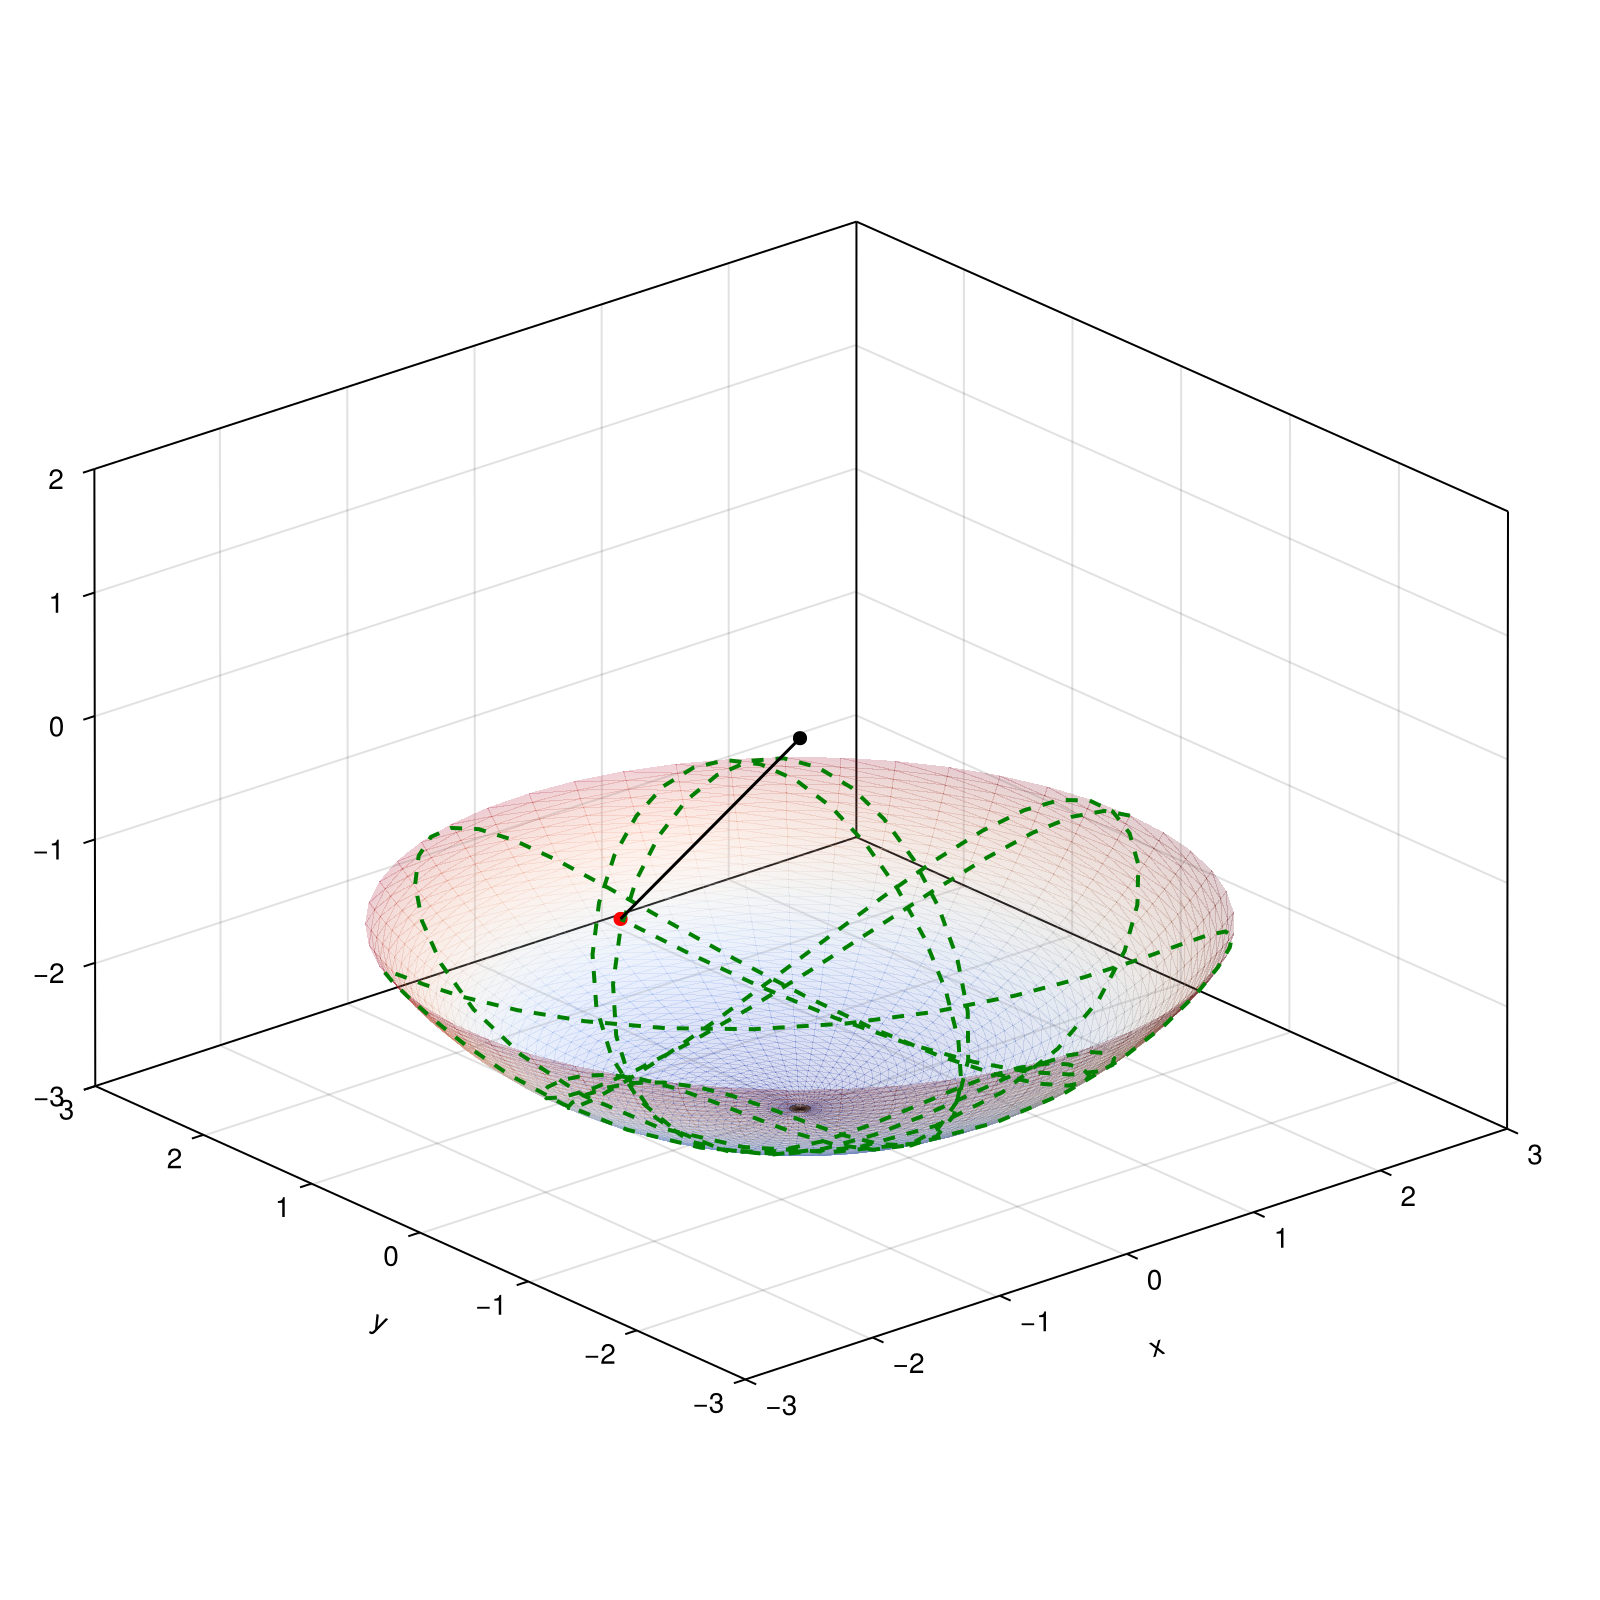

In [55]:
x0, y0, z0 = to_cartesian(sol[1,1], sol[2,1], p[2])
trajectory = Observable(Point3f[(x0, y0, z0)])
fig = Figure(size = (800, 800))
ax = Axis3(fig[1, 1])
surface!(ax, X, Y, Z, colormap = :coolwarm,  alpha = 0.2, backlight = 1, invert_normals = true, transparency = true)
scatter!(ax, xₜ, yₜ, zₜ, markersize = 10, color = :red) 
scatter!(ax, 0, 0, 0, markersize = 10, color = :black)
lines!(ax, trajectory[], color = :green, linestyle = :dash, linewidth = 2)
lines!(ax, rodx, rody, rodz, color = :black)
xlims!(ax, -l, l)
ylims!(ax, -l, l)
zlims!(ax, -l, 2)
record(fig, "spherical_pendulum_jul.gif", 0:0.05:total_time, framerate = 20) do f 
    frames[] = f
    new_Point = Point3f((xₜ[], yₜ[], zₜ[]))
    trajectory[] = push!(trajectory[], new_Point)    
end
fig

# Phase Space

The phase space is the space of all possible states of the system. In this case, I will plot $\dot \theta$ vs $\theta$.

In [56]:
# Get Average Lz of the above trajectory
Lz = sum(m * l^2 * sol[4,:] .* sin.(sol[1,:]).^2)/length(sol[1,:])
myLz = Lz
function Energy(θ, θ̇, Lz, p)
    # Energy of the spherical pendulum
    g, l, m = p
    Term1 = 0.5m .* l^2 .* θ̇.^2
    Term2 = Lz^2 ./ (2m * l^2 * sin.(θ).^2)
    Term3 = m * g * l * (1 .- cos.(θ))
    return Term1 + Term2 + Term3
end
# Get the energy of the above trajectory at each point of the phase space
θ = range(0, 2π, length = 1000)
θ̇ = range(-3π, 3π, length = 1000)
θ_Mesh= θ * ones(1000)'
θ̇_Mesh = ones(1000) * θ̇'
E = Energy(θ_Mesh, θ̇_Mesh, Lz, p);

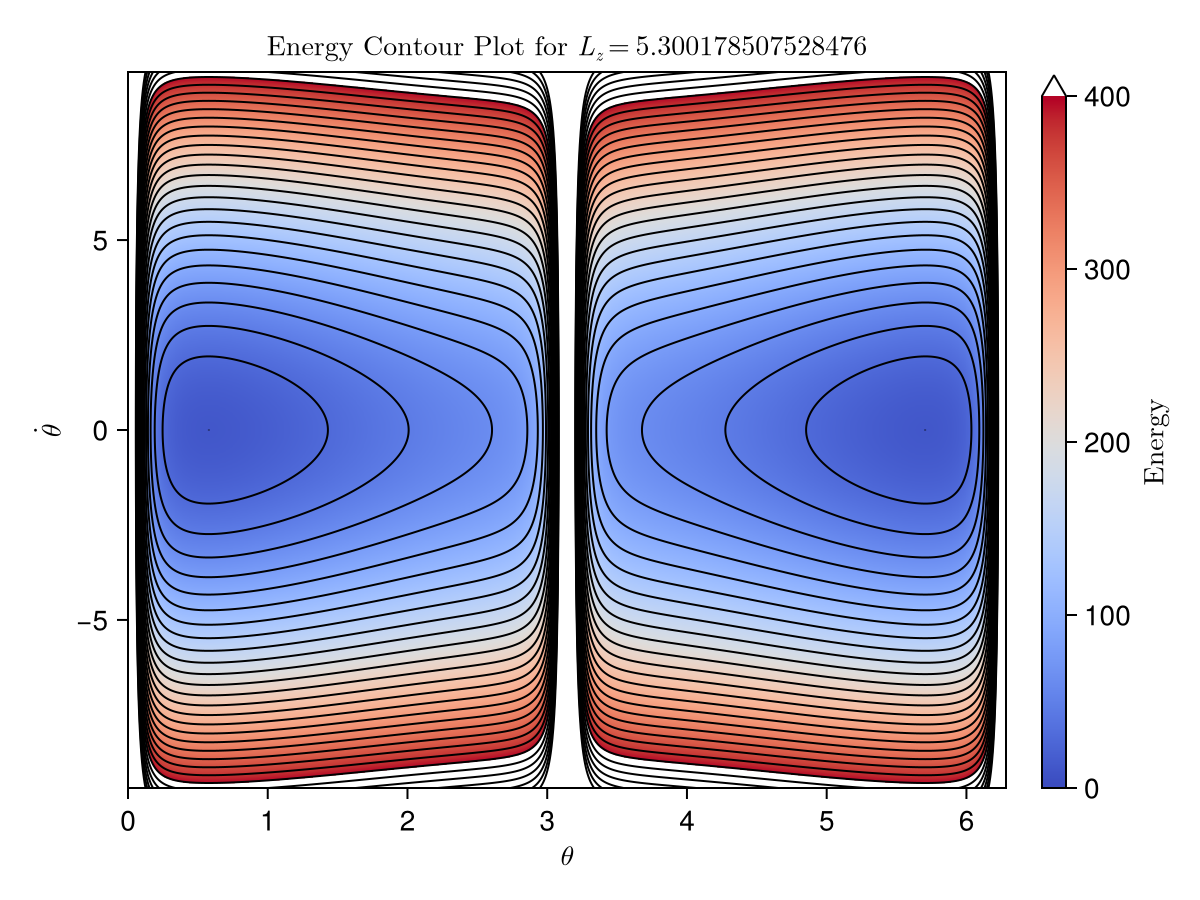

In [57]:
# plot the energy contour plot
min_bounds = minimum(E)
max_bounds = 500 
fig = Figure()
ax = Axis(fig[1, 1], xlabel = L"\theta", ylabel = L"\dot\theta", title = L"Energy Contour Plot for $ L_z = %$(Lz)$")
con = heatmap!(ax, θ, θ̇, E, colorrange=(0, 400), colormap =:coolwarm, highclip=:white, interpolate = true)
contour!(ax, θ, θ̇, E, levels =range(min_bounds, max_bounds, length = 30), color=:black, transparency = true)
Colorbar(fig[1,2], con, label = L"\text{Energy}")
xlims!(ax, 0, 2π)
ylims!(ax, -3π, 3π)
fig

We can even animate it as Lz changes

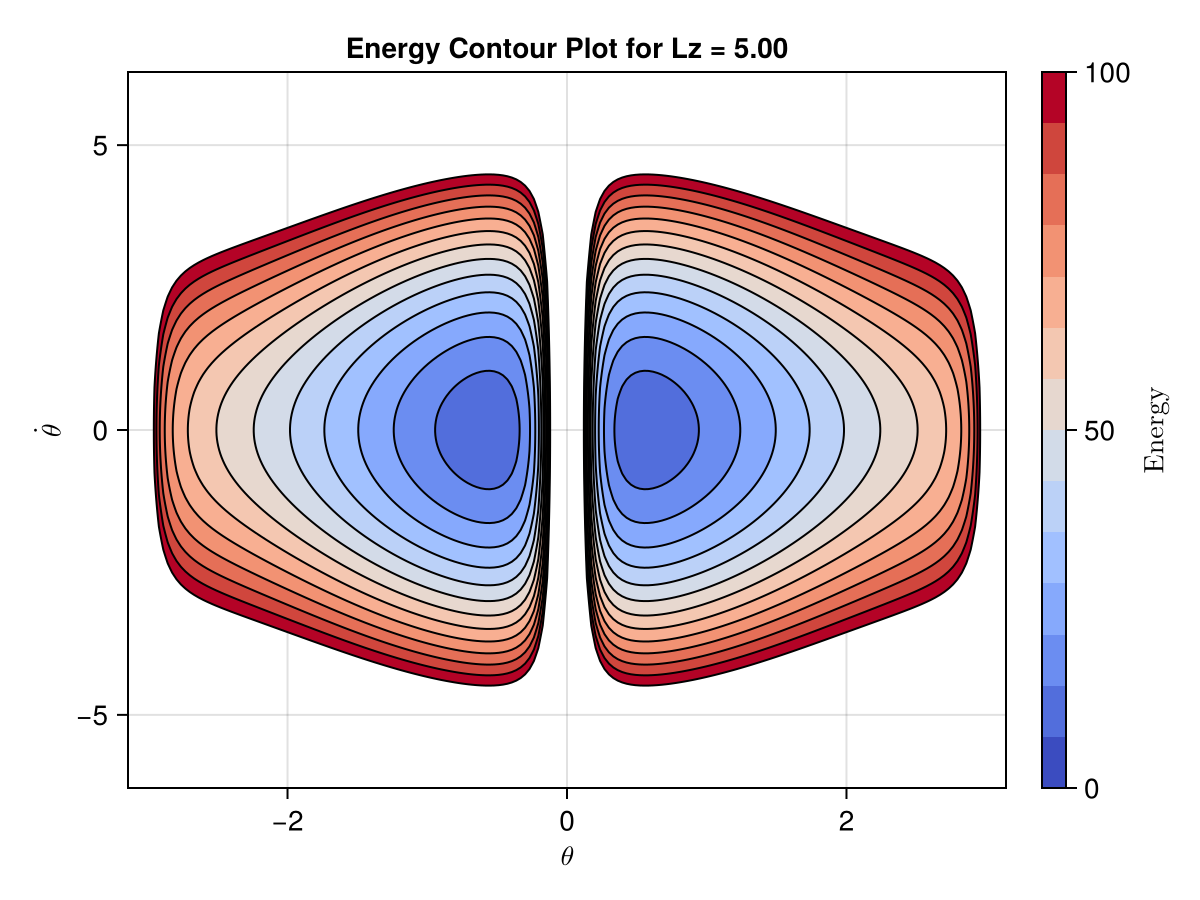

In [58]:
num_points = 200
θ = range(-π, π, length = num_points)[2:end-1]
θ̇ = range(-2π, 2π, length = num_points)
θ_Mesh = θ * ones(num_points)'
θ̇_Mesh = ones(num_points - 2) * θ̇'

Lz = Observable(0.0)
energies = @lift Energy(θ_Mesh, θ̇_Mesh, $Lz, p)
bounds =range(0, 100, 15)
titlestr = @lift "Energy Contour Plot for Lz = " * @sprintf "%2.2f" $Lz


fig = Figure()
ax = Axis(fig[1, 1], xlabel = L"\theta", ylabel = L"\dot\theta", title = titlestr)
con = contourf!(ax, θ, θ̇, energies, levels = bounds, colormap = :coolwarm, transparency = true)
contour!(ax, θ, θ̇, energies, levels = bounds, color = :black, linewidth = 1)
Colorbar(fig[1,2], con, label = L"\text{Energy}")
xlims!(ax, -π, π)
ylims!(ax, -2π, 2π)
record(fig, "spherical_pendulum_energy_jul.gif", 0:0.1:5, framerate = 15) do f
    Lz[] = f
end
fig

For Vizualization, we can plot it in 3-D where z is the Energy.

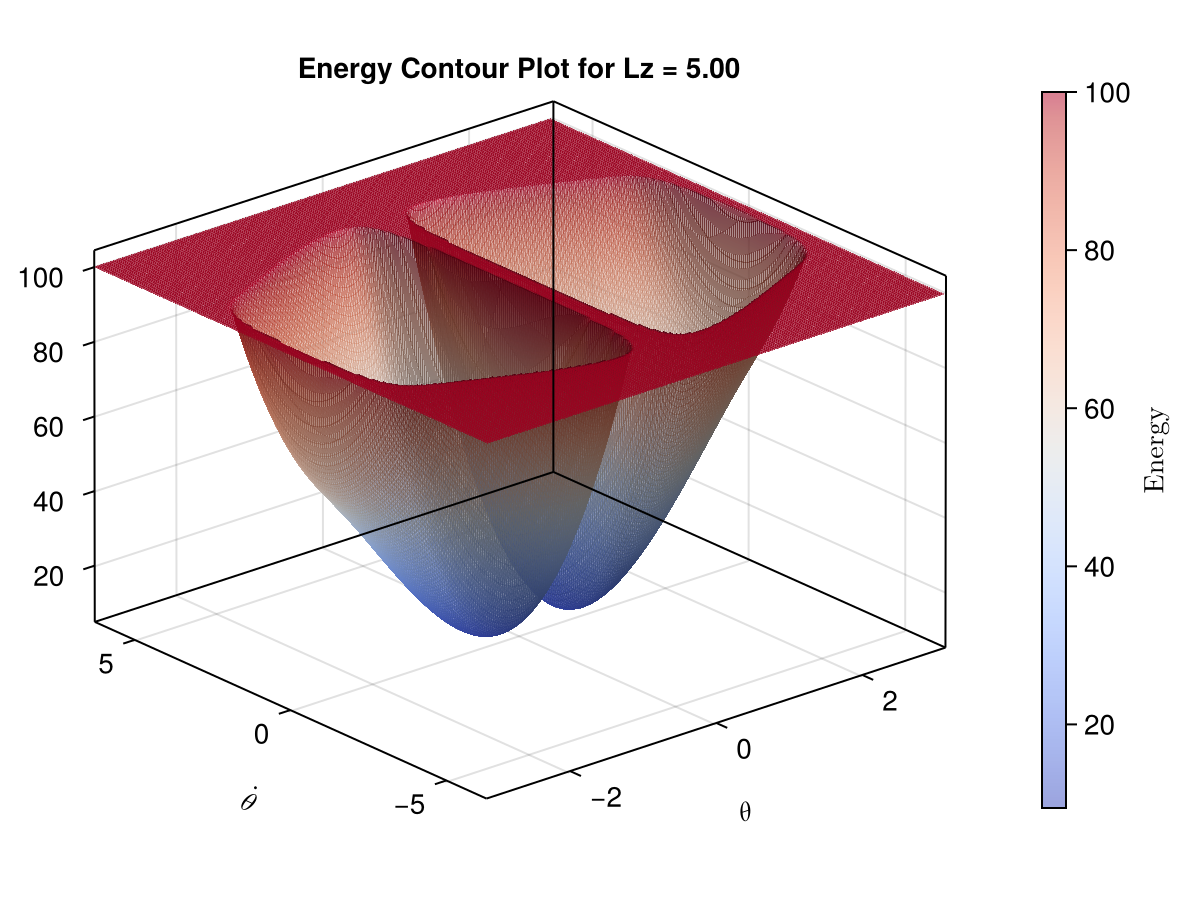

In [59]:
caped_energies = @lift min.($energies, 100)
fig = Figure()
ax = Axis3(fig[1, 1], xlabel = L"\theta", ylabel = L"\dot\theta", title = titlestr)
con = surface!(ax, θ, θ̇, caped_energies, colormap = :coolwarm, transparency = true, alpha = 0.5)
Colorbar(fig[1,2], con, label = L"\text{Energy}")
xlims!(ax, -π, π)
ylims!(ax, -2π, 2π)
record(fig, "spherical_pendulum_energy_surface_jul.gif", 0:0.1:5, framerate = 15) do f
    Lz[] = f
end
fig

Finding the stable fixed point as a function of Lz. We can clearly see the asymptotic behavior of the function near $\frac{\pi}2$

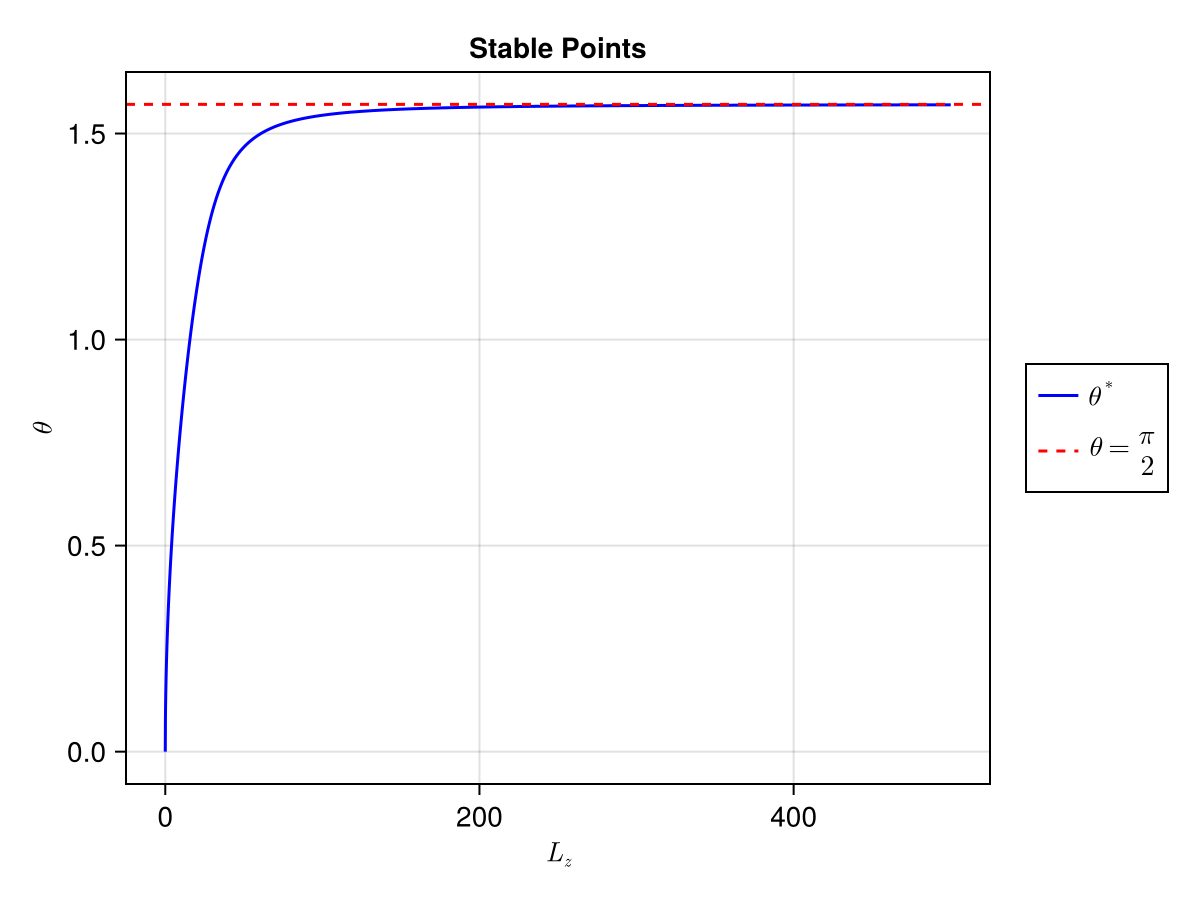

In [60]:

function stable_point(θ, Lz, p)
    # Derivative of the function when θ̇ = 0
    g, l, m = p
    return Lz^2 ./ (m^2 * l^4 .* sin.(θ).^3) .* cos.(θ) .- g/l .* sin.(θ) 
end
Lzs = 0:0.1:500
# Finding the zeros of the Derivative will give us the minimum of the function (fixed point)
stable = [find_zero(θ -> stable_point(θ, Lz, p), 0.1) for Lz in Lzs];
fig = Figure()
ax = Axis(fig[1, 1], xlabel = L"L_z", ylabel = L"\theta", title = "Stable Points")
lines!(ax, Lzs, stable, color = :blue, label = L"\theta^*")
hlines!(ax, [π/2], color = :red, linestyle = :dash, label = L"\theta = \frac{\pi}{2}")
Legend(fig[1, 2], ax)
fig


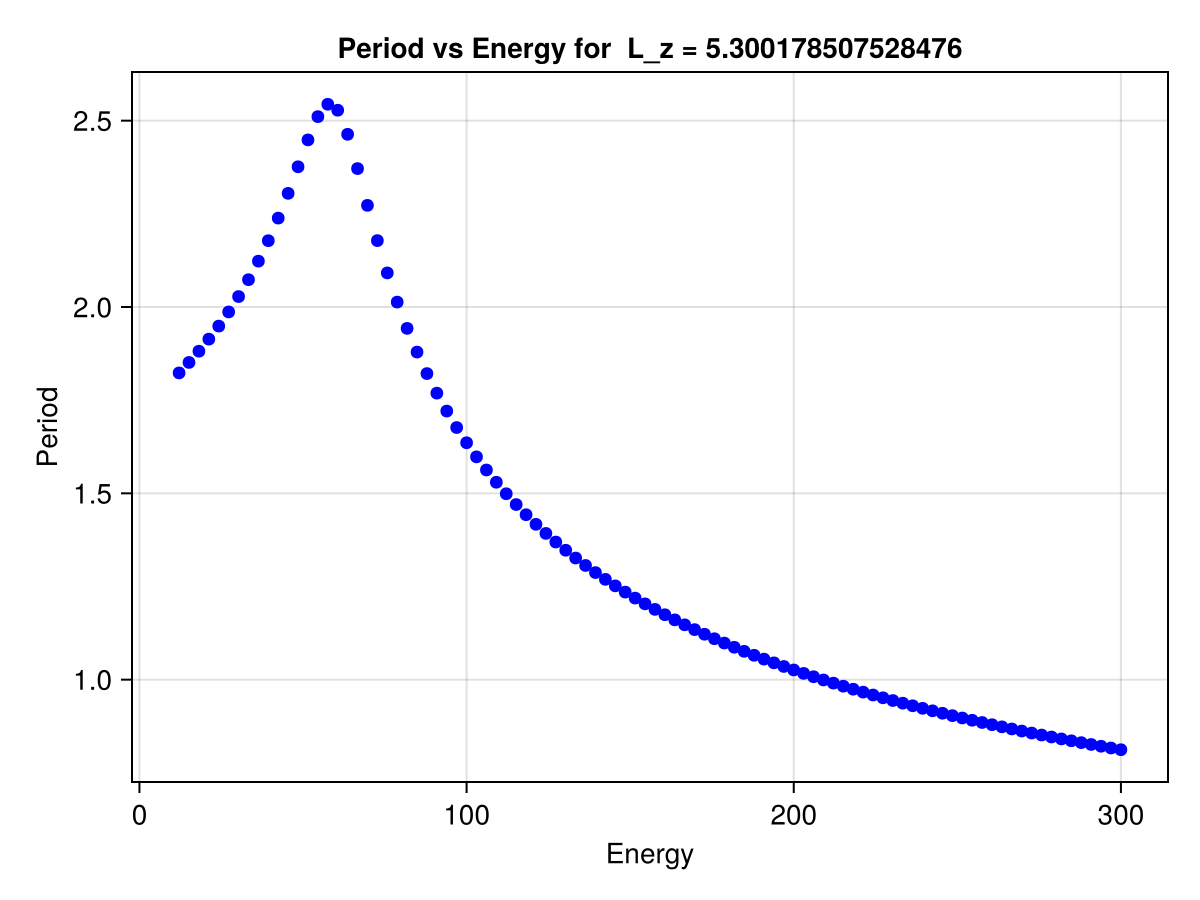

In [61]:

function Energy0(E, θ, θ̇, Lz, p)
    return  Energy(θ, θ̇, Lz, p) - E
end
function Period(Lz, E, p)
    g, l, m = p
    # Find the initial and final points of the trajectory to integrate over
    if Lz == 0.0
        θ̇ = 0.0
        if E >= 2 * m * g * l
            # The pendulum is in the part of the phase space where it will never stop
            KE = E - 2 * m * g * l
            θ₀ = -π
            θₜ = π
            θ̇ = sqrt(abs(2KE / (m*l^2)))
        elseif E == 0.0
            return NaN
        else 
            # Here the pendulum will stop at the top so we can set θ̇ = 0 and find the corresponding θ₀ and θₜ
            θ̇ = 0.0
            θₜ = find_zero(θ -> Energy0(E, θ, θ̇, Lz, p), [eps(), π-eps()])
            θ₀ = find_zero(θ -> Energy0(E, θ, θ̇, Lz, p), [-π+eps(), -eps()])
        end
    else
        # Here all trajectories also path through θ̇ = 0
        θ̇ = 0.0
        θmin = find_zero(θ -> stable_point(θ, Lz, p), 0.1) + eps()
        Emin = Energy(θmin, θ̇, Lz, p)
        if E < Emin
            return NaN
        end
        θ₀ = find_zero(θ -> Energy0(E, θ, θ̇, Lz, p), (0.0001, θmin))
        θₜ = find_zero(θ -> Energy0(E, θ, θ̇, Lz, p), (θmin, π-0.001))
    end 
    # Integrate over the path to get the Period
    function Ueff(θ, Lz, p)
        g, l, m = p
        if Lz == 0.0
            return m * g * l * (1 - cos(θ))
        end
        return m * g * l * (1 - cos(θ)) + Lz^2 / (2m * l^2 * sin(θ)^2)
    end
    integrand(θ) = 1 / sqrt(abs(2 * (E - Ueff(θ, Lz, p))))
    # Here the integrand should be 1 / sqrt(2 * (E - Ueff(θ, Lz, p))
    # But because of numerical error, the difference between E and Ueff can 
    # be a very small negative number, which will cause problems with the sqrt
    # So we take the absolute value of the difference
    quadrature = hquadrature(integrand, θ₀, θₜ; rtol=1e-4)
    # Here I multiply by 2 because this is only half of the trajectory
    return 2 * l * sqrt(m) * quadrature[1], θ₀, θₜ, θ̇
end
E_space = range(0.0, 300.0, length = 100)
Periods = [Period(myLz, E, p)[1] for E in E_space]
fig = Figure()
ax = Axis(fig[1, 1], xlabel = "Energy", ylabel = "Period", title = "Period vs Energy for  L_z = $myLz")
scatter!(ax, E_space, Periods, color = :blue)
fig

In [62]:
E = 200.0
T, θ₀, θₜ, θ̇ = Period(myLz, E, p)
ϕ = 0
if θ₀ > θₜ
    θ₀, θₜ = θₜ, θ₀
end
y₀ = [θ₀, ϕ, θ̇, myLz/(m*l^2 * sin(θ₀)^2)]
problem = ODEProblem(spherical_pendulum!, y₀, (0.0, T), p)  
sol = solve(problem, Vern9())
phi_bounds = abs(sol[2,end] - ϕ)
# After a Period in θ we check how much the ϕ has changed
# This will give us the period in ϕ
T_ϕ =  T * 2π/phi_bounds
print("The period in ϕ is ")
println(T_ϕ)

The period in ϕ is 1.0283790966061412
